# Project: Telomeres Analysis (length of the telomeres)

## 1. Import of the required modules

In [19]:
import glob                   
import pandas as pd
from scipy import stats
from scipy.stats import ttest_ind
import seaborn as sns

## 2. Files selection for the analysis

In [20]:
groups = []
def provide_files():
    """ asks user to provide the file's name for the analysis"""
    pattern = None
    while pattern != "":
        pattern = input("Provide the file name that you want to analyze (enter to finish):")
        if pattern:
            groups.append(glob.glob(f"*{pattern}*"))
provide_files()

Provide the file name that you want to analyze (enter to finish):cells_Reference_
Provide the file name that you want to analyze (enter to finish):cells_MQPS170003
Provide the file name that you want to analyze (enter to finish):cells_MGC9orf72_
Provide the file name that you want to analyze (enter to finish):cells_JPC9orf72
Provide the file name that you want to analyze (enter to finish):


In [21]:
groups

[['cells_Reference_DAPI_Telo_gH2AX_1.txt',
  'cells_Reference_DAPI_Telo_gH2AX_10.txt',
  'cells_Reference_DAPI_Telo_gH2AX_11.txt',
  'cells_Reference_DAPI_Telo_gH2AX_12.txt',
  'cells_Reference_DAPI_Telo_gH2AX_13.txt',
  'cells_Reference_DAPI_Telo_gH2AX_14.txt',
  'cells_Reference_DAPI_Telo_gH2AX_15.txt',
  'cells_Reference_DAPI_Telo_gH2AX_16.txt',
  'cells_Reference_DAPI_Telo_gH2AX_17.txt',
  'cells_Reference_DAPI_Telo_gH2AX_18.txt',
  'cells_Reference_DAPI_Telo_gH2AX_19.txt',
  'cells_Reference_DAPI_Telo_gH2AX_2.txt',
  'cells_Reference_DAPI_Telo_gH2AX_20.txt',
  'cells_Reference_DAPI_Telo_gH2AX_3.txt',
  'cells_Reference_DAPI_Telo_gH2AX_4.txt',
  'cells_Reference_DAPI_Telo_gH2AX_5.txt',
  'cells_Reference_DAPI_Telo_gH2AX_6.txt',
  'cells_Reference_DAPI_Telo_gH2AX_7.txt',
  'cells_Reference_DAPI_Telo_gH2AX_8.txt',
  'cells_Reference_DAPI_Telo_gH2AX_9.txt'],
 ['cells_MQPS170003_DAPI_Telo_gH2AX_1.txt',
  'cells_MQPS170003_DAPI_Telo_gH2AX_10.txt',
  'cells_MQPS170003_DAPI_Telo_gH2AX_11.

## 3. Groups generation for the analysis

##### combines files within each group

In [23]:
try:
    df_combined = [pd.concat([pd.read_csv(file_name, sep="\t") for file_name in group]) for group in groups]
except UnicodeDecodeError:
    print ("Error: The data frames must be equal!")

## 4. Preparation of the data for the analysis

##### The DataProcessor (separately for each group) calculates new values based on the provided values within the columns, places them to new column, extracts requried columns, provides final mean values for unique values and finaly combines the groups in one data frame. 

In [24]:
class DataProcessor: 
    
    def __init__(self):
        self.df_combined_clean = []
        self.df_AreaXIntensity = []
        self.df_selected = []
        self.new_dataset = []
        self.dataset_grouped = []
        self.dataset_grouped_combined = []
        self.data = None
    
    @property
    def data(self):
        return self._data
    
    @data.setter
    def data(self, data):
        self._data = data
    
    def data_cleaning(self):
        """removes rows with missing values"""
        for i in df_combined:
            df_clean = i.dropna()
            self.df_combined_clean.append(df_clean)
    
    def create_column(self):
        """creats new column with the calculation (area x intrnsity) based on existing values """ 
        for df in self.df_combined_clean:
            df["AreaXIntensity"] = df["Area"] * df["Mean"]
            self.df_AreaXIntensity.append(df)
            
    def select_column(self):
        """selects required columns"""
        for df_group in self.df_AreaXIntensity:
            selected_columns = df_group.loc[:, ("CellId", "AreaXIntensity")]
            self.df_selected.append(selected_columns)
            
    def rename_column(self): 
        """renames column for final values"""
        for df_telomeres in self.df_selected:
            df_telomeres.rename({"AreaXIntensity" : "mean_AreaXintensity"}, axis=1, inplace=True)
            self.new_dataset.append(df_telomeres)  
            
    def group_cell(self):
        """grupes values within the same cell and returns mean value for each cell""" 
        for df_ in self.new_dataset:
            z = df_.groupby(["CellId"]).mean()
            self.dataset_grouped.append(z)
    
    def combine_df(self): 
        """combines data frame creating final single data frame"""
        keys = []
        for key in range(len(self.dataset_grouped)):
            keys.append(key)
        self.dataset_grouped_combined = pd.concat([element for element in self.dataset_grouped], keys = [*keys], \
                                             names=['GroupID'])
    def reset_index(self): 
        """removes indexes for particular df to exchange them on group ID"""    
        self.data = self.dataset_grouped_combined.reset_index() 

## 5. Execution of the DataProcessor

In [25]:
processed_data = DataProcessor()
processed_data.data_cleaning()
processed_data.create_column()
processed_data.select_column()
processed_data.rename_column()
processed_data.group_cell()
processed_data.combine_df()
processed_data.reset_index()

## 6. Extraction of the final data frame

In [26]:
final_data = processed_data.data

## 7. Final data frame

In [27]:
final_data.head()

,GroupID,CellId,mean_AreaXintensity


## 8. Export to csv file

In [12]:
final_data.to_csv(r'final_data_frame.csv')

## 9. Statistical analysis
#### It returns the results for t-test or One-way ANOVA and saves them to csv file

In [13]:
def get_stats(df):
    """caluclates t-test or one-way ANOVA depending on number of the groups and saves the results to .txt file"""
    if  df.GroupID.nunique() == 2:
        t_data = df.groupby(["GroupID"])
        group1 = t_data.get_group(0)
        group2 = t_data.get_group(1)
        t_test_results = ttest_ind(group1["mean_AreaXintensity"], group2["mean_AreaXintensity"])
        print (f"{t_test_results}")
        with open("stats.csv", "w", newline="") as csvfile:
            csvfile.write(f"{t_test_results}")
    else:
        k = len(pd.unique(df.GroupID))
        N = len(df.values)
        n = df.groupby('GroupID').size()[0]
        DFbetween = k - 1
        DFwithin = N - k
        DFtotal = N - 1
        SSbetween = (sum(df.groupby('GroupID').sum()['mean_AreaXintensity']**2)/n) \
                    - (df['mean_AreaXintensity'].sum()**2)/N
        sum_y_squared = sum([value**2 for value in df['mean_AreaXintensity'].values])
        SSwithin = sum_y_squared - sum(df.groupby('GroupID').sum()['mean_AreaXintensity']**2)/n
        SStotal = sum_y_squared - (df['mean_AreaXintensity'].sum()**2)/N
        MSbetween = SSbetween/DFbetween
        MSwithin = SSwithin/DFwithin
        F = MSbetween/MSwithin
        p = stats.f.sf(F, DFbetween, DFwithin)
        eta_sqrd = SSbetween/SStotal
        print (f"The result for One-way ANOVA is F={F}, pvalue={p}, eta_sqrd={eta_sqrd}")
        with open("stats.csv", "w", newline="") as csvfile:
            csvfile.write(f"The result for One-way ANOVA is F={F}, pvalue={p}, eta_sqrd={eta_sqrd}")
            
get_stats(final_data)

The result for One-way ANOVA is F=-126.0351007619037, pvalue=1.0, eta_sqrd=1.6648898043341744


## 10. Data visualisation with graphs

##### It asks user to rename the groups and creats lists of new names, then creats dictionary with assigned new names and finaly uses the dictionary to renamed groups

In [14]:
keys_GroupID = list(range(final_data.GroupID.nunique())) 
values_names = [] 
  
for names in range(final_data.GroupID.nunique()): 
    names = input("Provide new name: ") 
    values_names.append(names)

Provide new name: control 1
Provide new name: control 2
Provide new name: C9orf72 1
Provide new name: C9orf72 2


In [15]:
renamed = {keys_GroupID[i]: values_names[i] for i in range(len(keys_GroupID))}

In [16]:
final_data['groups'] = final_data['GroupID'].map(renamed)

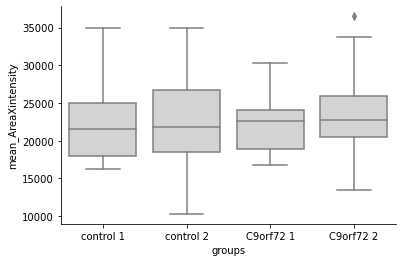

In [17]:
def data_vis_BoxPlot(df1):
    """creates box plot based on final data frame with new names and saves it"""
    boxplot_telomeres = sns.boxplot(x=df1["groups"], y=df1["mean_AreaXintensity"], palette=["lightgray"], data=df1)
    sns.despine(offset=0)
    fig = boxplot_telomeres.get_figure()
    fig.savefig("boxplot_telomeres.png") 
    
data_vis_BoxPlot(final_data)

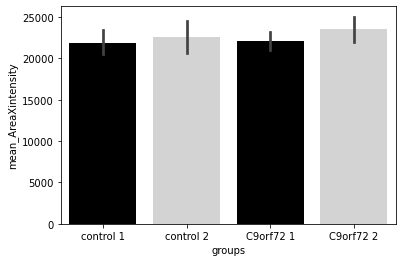

In [18]:
def data_vis_BarPlot(df2):
    """creats bar plot on final data frame"""
    barplot_telomeres = sns.barplot(x=df2["groups"], y=df2["mean_AreaXintensity"], \
                                    palette=["k", "lightgray"], data=df2)
    
data_vis_BarPlot(final_data)